# Reinforcement Learning dengan Deep Q-Network untuk Game Demon Attack

Pandega Abyan Zumarsyah (18/424977/TK/46672)

---

Ini merupakan pengujian Reinforcement Learning dengan Deep Q-Netwrok untuk Game Atari bernama Demon Attack. Environment didapatkan dari [OpenAI Gym](https://gym.openai.com/envs/#atari). Pengolahan dilakukan pada citra dari game dengan basis PyTorch. Output dari pengujian ini meliputi perbandingan skor dan history antara trained agent dengan random, model dari trained agent, serta video pengujian baik untuk trained agent maupun random. 

Kode yang digunakan di sini tentu berasal dari berbagai referensi, namun utamanya adalah dari https://github.com/qarchli/dqn-on-space-invaders. Meski begitu, terdapat banyak penyesuaian untuk mempersingkat kodenya, mempercepat pengolahannya, dan meningkatkan hasilnya. Itu tidak bisa dilakukan tanpa memahami kodenya secara mendalam. Apalagi, masalah yang dihadapi juga berbeda sehingga pendekatannya belum tentu bisa sama. 

## Initialization

### Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import gym
import os
from collections import namedtuple, deque

import torch
import torch.nn as NN
import torch.nn.functional as Func
import torch.optim as Optim

from google.colab import drive

from IPython.display import HTML
from base64 import b64encode

In [ ]:
DEV = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Connect to Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Project AI - Reinforcement Learning on Atari Game/Percobaan-9/'

### Download and Extract ROM

In [ ]:
!mkdir /content/Atari-ROM/
!wget http://www.atarimania.com/roms/Roms.rar
!unrar e /content/Roms.rar /content/Atari-ROM/
!python -m atari_py.import_roms /content/Atari-ROM/

--2021-12-16 00:40:02--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   635KB/s    in 18s     

2021-12-16 00:40:20 (614 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/Atari-ROM/HC ROMS.zip                                36%  OK 
Extracting  /content/Atari-ROM/ROMS.zip                                   74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin fr

## Class and Function Definition

### Deep Q-Network Class

In [ ]:
class DQN(NN.Module):
    """Deep Q-Network"""

    def __init__(self, ukuran_action, seed):
        super(DQN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = NN.Conv2d(1, 32, 6, stride=4, padding=1)
        self.conv2 = NN.Conv2d(32, 64, 4, stride=2)
        self.conv3 = NN.Conv2d(64, 128, 2)
        self.fc1 = NN.Linear(168*18*8, 512)
        self.fc2 = NN.Linear(512, ukuran_action)

    def forward(self, state):
        """
        untuk memetakan suatu state ke action-values
        itu dilakukan dengan mengolah state dalam bentuk tensor melalui Neural Network
        """
        
        out = state.clone()
        out = out.view(-1, 1, 185, 95) # karena totalnya adalah 185x95 = 17575

        # Layer Konvolusi dengan ReLu sebagai fungsi aktivasi
        out = Func.relu(self.conv1(out))
        out = Func.relu(self.conv2(out))
        out = Func.relu(self.conv3(out))

        # Flattening pada tensor agar bisa masuk ke layer selanjutnya
        out = out.view(-1, 168*18*8) # karena totalnya adalah 168x18x8 = 24192

        # Layer Fully Connected dengan ReLu sebagai fungsi aktivasi
        out = Func.relu(self.fc1(out))

        # Layer Fully Connected yang menghasilkan nilai akhir
        out = self.fc2(out)

        return out

### Memory Class

In [ ]:
class Memori:
    """
    Memori untuk menyimpan pengalaman
    Pengalaman meliputi data: state, action, state_next, reward, gameover
    """

    def __init__(self, ukuran_action, ukuran_buffer, ukuran_batch, seed):
        self.memori = deque(maxlen=ukuran_buffer)
        self.Pengalaman = namedtuple("Pengalaman", field_names=["state", "action", "state_next", "reward", "gameover"])
        self.ukuran_action = ukuran_action
        self.ukuran_batch = ukuran_batch
        random.seed(seed)

    def __len__(self):
        """ukuran dari memori"""
        return len(self.memori)

    def tambahkan(self, state, action, state_next, reward, gameover):
        """untuk menambahkan pengalaman baru ke memori"""
        e = self.Pengalaman(state, action, state_next, reward, gameover)
        self.memori.append(e)

    def ambil_sampel(self):
        """untuk mengambil beberapa sampel pengalaman dari memori"""
        
        Pengalaman = random.sample(self.memori, k=self.ukuran_batch)

        # Data yang None dibuang kemudian tipe datanya disesuaikan
        states = torch.cat([e.state for e in Pengalaman if e is not None])
        actions = torch.from_numpy(np.vstack([e.action for e in Pengalaman if e is not None])).long().to(DEV)
        states_next = torch.cat([e.state_next for e in Pengalaman if e is not None])
        rewards = torch.from_numpy(np.vstack([e.reward for e in Pengalaman if e is not None])).float().to(DEV)
        gameovers = torch.from_numpy(np.vstack([e.gameover for e in Pengalaman if e is not None]).astype(np.uint8)).float().to(DEV)
        
        return (states, actions, states_next, rewards, gameovers)

### Agent Class

In [ ]:
class Agent():
    """Agent senantiasa berinteraksi dan belajar dari environment"""

    def __init__(self, ukuran_action, seed, 
                 learning_rate=1e-3, diskon=0.99, ukuran_buffer=int(1e5), 
                 ukuran_batch=64, update_period=100):

        self.ukuran_action = ukuran_action
        self.seed = random.seed(seed)
        self.ukuran_batch = ukuran_batch
        self.update_period = update_period
        self.diskon = diskon

        # Inisialisasi Q-Network dan Optimizer
        self.Qnetwork_awal = DQN(ukuran_action, seed).to(DEV)
        self.Qnetwork_akhir = DQN(ukuran_action, seed).to(DEV)
        self.optimizer = Optim.Adam(self.Qnetwork_awal.parameters(), lr=learning_rate)

        # Inisialisasi Memori
        self.memori = Memori(ukuran_action, ukuran_buffer, ukuran_batch, seed)
        
        # Inisialisasi Timestep
        self.timestep = 0

    def preprocess(self, image, normalize = True):
        """
        Pengolahan awal pada citra dari game sebelum digunakan
        Ini meliputi konversi ke grayscale, cropping, permutasi, dan konversi ke tensor
        """

        # Konversi ke grayscale
        state = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
        state = state[..., np.newaxis]

        # Normalisasi
        if (normalize == True):
            state = state/255

        # Cropping dan Permutasi
        state = state[15:200, 30:125, :]
        state = state.transpose(2, 0, 1)

        # Konversi ke tensor
        state = torch.from_numpy(state)
        state = state.float().unsqueeze(0).to(DEV)

        return state

    def action(self, state_, epsilon=0):
        """
        Pemilihan aksi melalui prediksi action-value berdasarkan state
        Itu juga berdasarkan Epsilon-greedy Action Selection
        Jika epsilon tinggi, maka lebih condong ke mencari cara baru
        Jika epsilon rendah, maka lebih condong ke memaksimalkan yang didapatkan
        """

        if random.random() > epsilon:
            state = self.preprocess(state_, normalize=False)
            # Q-Network membuat prediksi action-value berdasarkan state
            self.Qnetwork_awal.eval()
            with torch.no_grad():
                action_values = self.Qnetwork_awal(state)
            # Q-Network melanjutkan training
            self.Qnetwork_awal.train()
            return np.argmax(action_values.cpu().data.numpy())

        else:
            return random.choice(np.arange(self.ukuran_action))

    def step(self, state_, action, state_next_, reward, gameover):
        """
        Pengalaman baru disimpan ke memori dan digunakan untuk learning pada saat tertentu
        """

        # Pengolahan awal untuk citra state dan state_next
        state = self.preprocess(state_.copy())
        state_next = self.preprocess(state_next_.copy())

        # Simpan pengalaman baru ke dalam memori
        self.memori.tambahkan(state, action, state_next, reward, gameover)

        # Learn setiap update_period jika ada cukup pengalaman di memori
        # Learn dari sampel pengalaman yang ada di memori
        time_to_learn = ((self.timestep + 1) % self.update_period == 0) and (len(self.memori) > self.ukuran_batch)
        if time_to_learn:
            pengalaman = self.memori.ambil()
            self.learning(pengalaman)

    def learning(self, Pengalaman):
        """
        Update parameter berdasarkan data pengalaman yang ada
        Update nya dengan menghitung loss untuk diminimisasi
        """

        states, actions, states_next, rewards, gameovers = Pengalaman

        criterion = torch.nn.MSELoss()
        self.Qnetwork_awal.train()
        self.Qnetwork_akhir.eval()

        prediksi_label = self.Qnetwork_awal(states).gather(1, actions)

        with torch.no_grad():
            labels_next = self.Qnetwork_akhir(states_next).detach().max(1)[0].unsqueeze(1)

        labels = rewards + ((1 - gameovers) * labels_next * self.diskon)

        loss = criterion(prediksi_label, labels).to(DEV)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update Q-Network
        self.Qnetwork_akhir.load_state_dict(self.Qnetwork_awal.state_dict())

### Train Function

In [ ]:
def train(envi, agent, n_episodes=100, max_timesteps=10000, 
          epsi_start=1.0, epsi_end=0.01, epsi_decay=0.999, target_skor=1000):
    """
    Training selama n_episodes dengan max_timesteps untuk tiap episode
    Ketika training, epsilon akan berubah dari epsi_start ke epsi_end dengan laju epsi_decay
    """
    
    # list yang berisi skor untuk tiap episode
    list_skor = []

    epsi = epsi_start
    for episode in range(1, n_episodes + 1):
        state = envi.reset()
        skor = 0
        for timestep in range(max_timesteps):
            # Penentuan action
            action = agent.action(state, epsi)
            # Observasi hasil action
            state_next, reward, gameover, _ = envi.step(action)
            # Penyimpanan pengalaman dan learning
            agent.step(state, action, state_next, reward, gameover)

            # Update
            state = state_next
            skor = skor + reward
            list_skor.append(skor)
            # Penyusutan Epsilon
            epsi = max(epsi * epsi_decay, epsi_end)

            # setiap SAVE_PERIOD
            if timestep % SAVE_PERIOD == 0:
                # Simpan skornya
                with open(PATH + 'train/list_skor', 'wb') as fp:
                    pickle.dump(list_skor, fp)
                # Simpan modelnya
                torch.save(agent.Qnetwork_awal.state_dict(), PATH + 'train/model.pth')
                print('\rEpisode {}\tTimestep = {}\tSkor = {:.2f}'.
                      format(episode, timestep, skor), end='')

            if gameover:
                print('\t---   selesai dalam {} timesteps dengan Skor = {}'.
                      format(timestep, skor))
                break

        if(skor > target_skor): 
            print('Training dihentikan karena skor sudah melebihi {}'.format(target_skor))
            break

    # Ketika training selesai
    # Simpan skornya (list_skor)
    with open(PATH + 'train/list_skor', 'wb') as fp:
        pickle.dump(list_skor, fp)
    # Simpan modelnya
    torch.save(agent.Qnetwork_awal.state_dict(), PATH + 'train/model.pth')

    return list_skor

### Random Play Function

In [ ]:
def play_random(envi, n_episodes, max_timesteps, seed=10):
    """
    Agent yang bermain secara acak untuk sekian episode
    Skor yang dihasilkan bisa digunakan sebagai pembanding
    """
    
    np.random.seed(seed)

    # list yang berisi skor untuk tiap episode
    skor_random = []

    for episode in range(1, n_episodes + 1):
        state = envi.reset()
        skor = 0
        for timestep in range(max_timesteps):
            # Pemilihan action nya random
            action = envi.action_space.sample()
            # Observasi hasil action
            state_next, reward, gameover, _ = envi.step(action)

            # Update
            state = state_next
            skor = skor + reward
            if gameover:
                print('Episode {} selesai dalam {} timesteps dengan Skor = {}'.
                      format(episode, timestep, skor))
                break
            # Simpan skor terbaru
            skor_random.append(skor)

    # Ketika selesai, simpan skor akhirnya
    with open(PATH + 'train/skor_random', 'wb') as f:
        pickle.dump(skor_random, f)

    return skor_random

### Plot History Function

In [ ]:
def plot_history(window = 12000):
    """
    Plot history untuk agent hasil training dan skor random sebagai pembanding
    """

    # Ambil data random skor
    with open(PATH + 'train/skor_random', 'rb') as f:
        skor_random = pickle.load(f)

    # Ambil data skor dari agent hasil training
    with open(PATH + 'train/list_skor', 'rb') as f:
        skor_agent = pickle.load(f)

    # list skor diolah dengan moving average
    skor_random_ = np.convolve(np.array(skor_random), np.ones((window,)) / window, mode='valid')
    skor_agent_ = np.convolve(np.array(skor_agent), np.ones((window,)) / window, mode='valid')

    plt.figure(figsize=(10, 4), dpi=120)
    plt.plot(skor_random_, 'k-', label="Random")
    plt.plot(skor_agent_, 'b-', label="Trained Agent")
    plt.xlabel('Timesteps')
    plt.ylabel('Skor')
    plt.legend(loc="best")
    plt.savefig(PATH + 'Histori-Skor.jpg')

### Test Function

In [ ]:
def test(envi, agent, n_tests=5, max_timesteps=10000):
    """
    Testing beberapa kali dengan tiap percobaannya bisa mencapai max_timesteps
    Output untuk tiap percobaan adalah video dan data terkait serta skor akhir
    """

    for tes in range(n_tests):
        if(agent == None): nama_folder = 'test-random'
        else: nama_folder = 'test'

        # Pengujian model untuk bermain game
        # Outputnya adalah video percobaan dan data lainnya
        envi = gym.wrappers.Monitor(envi, PATH + 'test/' + nama_folder + '-{}'.format(tes), force=True)

        # Pengujian model untuk bermain game
        # Outputnya adalah skor akhir
        observation = envi.reset()
        skor = 0
        for step in range(max_timesteps):
            if(agent == None):
                action = envi.action_space.sample()
            else:
                action = agent.action(observation)
            observation, reward, gameover, info = envi.step(action)
            skor = skor + reward
            if gameover:
                print('Percobaan ke-{} selesai dengan skor {}'.format(tes, skor))
                break

        envi.close()

## Run

### Preparation

### Parameter

In [ ]:
UKURAN_BUFFER = int(1e4)       # ukuran memory buffer
UKURAN_BATCH = 32              # ukuran batch untuk learning
DISKON = 0.90                  # discount factor
LEARNING_RATE = 1e-4           # learning rate
UPDATE_PERIOD = 500            # periode untuk update network nya
SAVE_PERIOD = 100              # periode untuk menyimpan data training dan network
MAX_TIMESTEPS = 5000           # timestep maksimum untuk setiap episode
N_EPISODES = 50                # banyaknya episode
EPSI_START = 1.0               # nilai epsilon di awal
EPSI_END = 0.001               # nilai epsilon minimum
EPSI_DECAY = 0.9999            # laju decay epsilon
TARGET_SKOR = 1000             # training berhenti jika target terpenuhi

### Load Environment

In [ ]:
envi = gym.make('DemonAttack-v0')

In [ ]:
envi.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

### Train Agent

In [ ]:
agent = Agent(ukuran_action=envi.action_space.n,
              seed=10,
              learning_rate=LEARNING_RATE,
              diskon=DISKON,
              ukuran_buffer=UKURAN_BUFFER,
              ukuran_batch=UKURAN_BATCH,
              update_period=UPDATE_PERIOD)

list_skor = train(envi, agent, n_episodes=N_EPISODES, max_timesteps=MAX_TIMESTEPS, 
         epsi_start=EPSI_START, epsi_end=EPSI_END, epsi_decay=EPSI_DECAY, target_skor=TARGET_SKOR)

Episode 1	Timestep = 800	Skor = 80.00	---   selesai dalam 850 timesteps dengan Skor = 90.0
Episode 2	Timestep = 2600	Skor = 310.00	---   selesai dalam 2644 timesteps dengan Skor = 325.0
Episode 3	Timestep = 500	Skor = 60.00	---   selesai dalam 593 timesteps dengan Skor = 60.0
Episode 4	Timestep = 2500	Skor = 190.00	---   selesai dalam 2513 timesteps dengan Skor = 190.0
Episode 5	Timestep = 2700	Skor = 265.00	---   selesai dalam 2759 timesteps dengan Skor = 295.0
Episode 6	Timestep = 1100	Skor = 140.00	---   selesai dalam 1129 timesteps dengan Skor = 140.0
Episode 7	Timestep = 900	Skor = 100.00	---   selesai dalam 914 timesteps dengan Skor = 100.0
Episode 9	Timestep = 1900	Skor = 385.00	---   selesai dalam 1912 timesteps dengan Skor = 385.0
Episode 10	Timestep = 4500	Skor = 295.00	---   selesai dalam 4542 timesteps dengan Skor = 295.0
Episode 12	Timestep = 2400	Skor = 385.00	---   selesai dalam 2444 timesteps dengan Skor = 385.0
Episode 13	Timestep = 3900	Skor = 1420.00	---   selesai da

### Random Play

In [ ]:
random_skor = play_random(envi, n_episodes = 40, max_timesteps = 1000, seed=10)

Episode 1 selesai dalam 396 timesteps dengan Skor = 50.0
Episode 2 selesai dalam 712 timesteps dengan Skor = 120.0
Episode 5 selesai dalam 701 timesteps dengan Skor = 70.0
Episode 6 selesai dalam 684 timesteps dengan Skor = 90.0
Episode 12 selesai dalam 666 timesteps dengan Skor = 90.0
Episode 15 selesai dalam 467 timesteps dengan Skor = 40.0
Episode 23 selesai dalam 551 timesteps dengan Skor = 60.0
Episode 24 selesai dalam 511 timesteps dengan Skor = 100.0
Episode 26 selesai dalam 798 timesteps dengan Skor = 120.0
Episode 33 selesai dalam 590 timesteps dengan Skor = 110.0
Episode 39 selesai dalam 499 timesteps dengan Skor = 20.0


## Evaluation

### Plot History

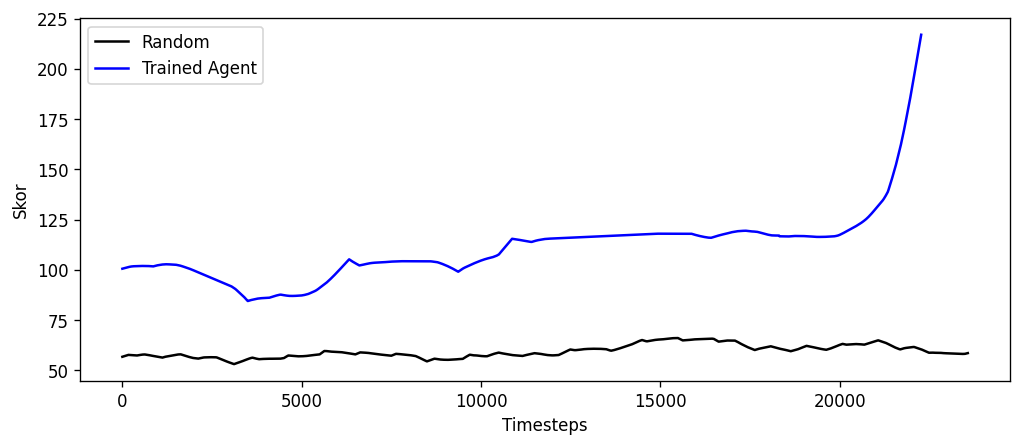

In [ ]:
plot_history()

### Test Agent

In [ ]:
test(envi, agent, n_tests=5, max_timesteps=10000)

Percobaan ke-0 selesai dengan skor 1200.0
Percobaan ke-1 selesai dengan skor 150.0
Percobaan ke-2 selesai dengan skor 370.0
Percobaan ke-3 selesai dengan skor 355.0
Percobaan ke-4 selesai dengan skor 880.0


In [ ]:
# Play video

test_num = 0
main_path = PATH + 'test/test-' + str(test_num)
video_file = [file for file in os.listdir(main_path) if '.mp4' in file][0]

video = open(main_path + '/' + video_file,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(video).decode()
HTML("""
<video width=350 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Test Random

In [ ]:
test(envi, agent=None, n_tests=5, max_timesteps=10000)

Percobaan ke-0 selesai dengan skor 110.0
Percobaan ke-1 selesai dengan skor 325.0
Percobaan ke-2 selesai dengan skor 130.0
Percobaan ke-3 selesai dengan skor 70.0
Percobaan ke-4 selesai dengan skor 110.0


In [ ]:
# Play video

test_num = 0
main_path = PATH + 'test/test-random-' + str(test_num)
video_file = [file for file in os.listdir(main_path) if '.mp4' in file][0]

video = open(main_path + '/' + video_file,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(video).decode()
HTML("""
<video width=350 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)